# Predictive Text Classification using Streaming Machine Learning

In [190]:
# Core utilities
import os, glob, re
from pathlib import Path
from tqdm.auto import tqdm

# Data and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ML utilities
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
import joblib


In [191]:
# For reproducibility
RANDOM_STATE = 42

# Load Dataset

In [193]:
data_dir = Path('.')
csv_files = list(data_dir.glob('**/*.csv'))
print(f"Found {len(csv_files)} csv files (first 10 shown):")
for p in csv_files[:10]:
    print(' -', p)

if not csv_files:
    raise FileNotFoundError('No CSV files found. Download and unzip the Kaggle dataset, or set `data_dir`.')

# we will pick the first CSV found — inspect it to detect columns
csv_path = csv_files[0]
print('\nUsing:', csv_path)

In [195]:
# Inspect header to find text & label columns (robust)
preview = pd.read_csv(csv_path, nrows=5)
print('\nPreview columns:\n', preview.columns.tolist())

text_candidates = ['text', 'tweet', 'content', 'text_clean', 'message']
label_candidates = ['label', 'sentiment', 'target', 'class']

cols = preview.columns.tolist()
text_col = next((c for c in cols if c.lower() in text_candidates), None)
label_col = next((c for c in cols if c.lower() in label_candidates), None)
print(f'Automatically detected text_col={text_col}, label_col={label_col}')

if text_col is None or label_col is None:
    print('Could not autodetect columns. Printing sample to help you set names manually:')
    display(preview)
    raise SystemExit('Please update text_col and label_col variables based on the preview above.')
else:
    print('Column detection successful! Proceeding with analysis...')


# Quick EDA

Loading a 100000 rows sample for EDA...
Sample shape: (100000, 2)

Class distribution (sample):
sentiment
0.0    100.0
Name: proportion, dtype: float64


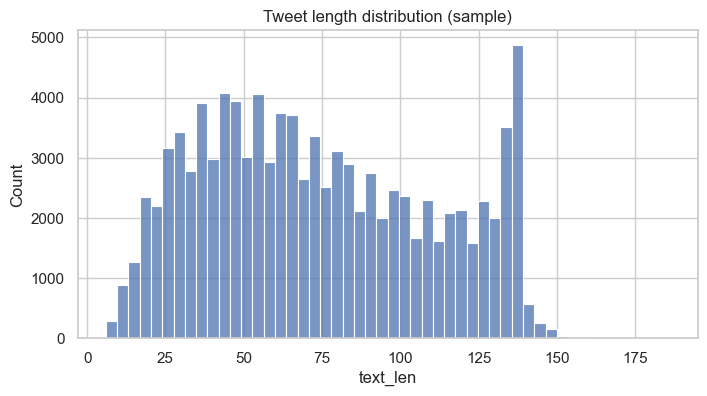

In [196]:
sample_n = 100000
print(f'Loading a {sample_n} rows sample for EDA...')

df_sample = pd.read_csv(csv_path, usecols=[text_col, label_col], nrows=sample_n).dropna()
print('Sample shape:', df_sample.shape)

df_sample['text_len'] = df_sample[text_col].str.len()
print('\nClass distribution (sample):')
print(df_sample[label_col].value_counts(normalize=True).mul(100).round(2))

plt.figure(figsize=(8,4))
sns.histplot(df_sample['text_len'], bins=50)
plt.title('Tweet length distribution (sample)')
plt.show()

# Text Preprocessing

In [197]:
# Download stopwords
import nltk
nltk.download('punkt')
nltk_stop_downloaded = False
try:
    nltk.download('stopwords')
    nnltk_stop_downloaded = True
except Exception:
    pass
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) if nnltk_stop_downloaded else set()

# cleaning function
def clean_text(s):
    if pd.isna(s):
        return ""
    s = str(s)
    s = s.lower()
    s = re.sub(r'http\S+', ' ', s) # remove urls
    s = re.sub(r'@\w+', ' ', s) # remove mentions
    s = re.sub(r'#', ' ', s) # remove hash sign
    s = re.sub(r'[^a-z0-9\s]', ' ', s) # remove punctuation
    s = re.sub(r'\s+', ' ', s).strip() # normalize whitespace
    return s

print(clean_text("@user I love this! Check https://x.com #awesome :)"))

# Baseline Model (TF-IDF + Logistic Regression)

In [198]:
baseline_n = 100000
print('Preparing baseline dataset...')

print("Checking full dataset label distribution:")
full_df = pd.read_csv(csv_path, usecols=[text_col, label_col])
print(full_df[label_col].value_counts())

# Sample strategically to ensure class balance
print("\nSampling strategically to include all classes...")
# Get samples from each class (focus on the two main classes for binary classification)
class_counts = full_df[label_col].value_counts()
print(f"Available classes: {class_counts.index.tolist()}")

# Take the two most frequent classes for binary classification
main_classes = class_counts.index[:2]
class_samples = []
samples_per_class = baseline_n // len(main_classes)

for class_val in main_classes:
    class_df = full_df[full_df[label_col] == class_val].head(samples_per_class)
    class_samples.append(class_df)
    print(f"Class {class_val}: {len(class_df)} samples")

df = pd.concat(class_samples, ignore_index=True)
print(f"Balanced dataset shape: {df.shape}")
print("Label distribution in balanced sample:")
print(df[label_col].value_counts())

df['clean_text'] = df[text_col].apply(clean_text)

# Encode labels - convert to string first to avoid float issues
df['label_str'] = df[label_col].astype(str)
le = LabelEncoder()
df['y'] = le.fit_transform(df['label_str'])
print('Label classes:', le.classes_)
print('Encoded label distribution:')
print(df['y'].value_counts())

# Verify we have at least 2 classes before splitting
if df['y'].nunique() < 2:
    raise ValueError(f"Only one class found: {le.classes_[0]}. Cannot train classification model.")

X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], df['y'], test_size=0.2, stratify=df['y'], random_state=RANDOM_STATE
)

print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Test set class distribution: {np.bincount(y_test)}")

# Vectorize
tfv = TfidfVectorizer(max_features=50000, ngram_range=(1,2), min_df=5)
X_train_tfidf = tfv.fit_transform(X_train)
X_test_tfidf = tfv.transform(X_test)

print('Train shape (tfidf):', X_train_tfidf.shape)

# Dimensionality reduction to speed up training
svd = TruncatedSVD(n_components=min(200, X_train_tfidf.shape[1]-1), random_state=RANDOM_STATE)
X_train_reduced = svd.fit_transform(X_train_tfidf)
X_test_reduced = svd.transform(X_test_tfidf)

# Train Logistic Regression baseline
clf = LogisticRegression(max_iter=200, solver='saga', n_jobs=-1, random_state=RANDOM_STATE)
clf.fit(X_train_reduced, y_train)

y_pred = clf.predict(X_test_reduced)
print('\nBaseline classification report:')

# Convert class names to strings for classification_report
target_names = [str(cls) for cls in le.classes_]
print(classification_report(y_test, y_pred, target_names=target_names))

# Calculate additional metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score (weighted): {f1:.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

joblib.dump({'tfidf': tfv, 'svd': svd, 'clf': clf, 'label_encoder': le}, 'baseline_model.joblib')
print('Baseline model saved to baseline_model.joblib')

# Scalable Training (Streaming with SGDClassifier)

In [199]:
print("Loading and shuffling data for balanced streaming...")

full_df = pd.read_csv(csv_path, usecols=[text_col, label_col])
print(f"Full dataset shape: {full_df.shape}")

# Drop NaN values and shuffle
full_df = full_df.dropna()
full_df = full_df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)  # Shuffle
print(f"Dataset after dropping NaN: {full_df.shape}")

print("Cleaning text...")
full_df['clean_text'] = full_df[text_col].apply(clean_text)

# Get all classes and encode labels
le_stream = LabelEncoder()
le_stream.fit(full_df[label_col].unique())
classes = le_stream.transform(le_stream.classes_)
print('Label classes:', le_stream.classes_)
print('Number of classes:', len(classes))

# Setup vectorizer and classifier
hv = HashingVectorizer(
    n_features=2**18, 
    alternate_sign=False, 
    ngram_range=(1,2),
    norm='l2'
)
clf_stream = SGDClassifier(
    loss='log_loss', 
    max_iter=1, 
    tol=None, 
    random_state=RANDOM_STATE,
    learning_rate='optimal',
    eta0=0.01,
    penalty='l2',
    alpha=0.0001
)
# Stream through shuffled data
chunksize = 100000
first_pass = True
processed = 0
total_chunks = (len(full_df) // chunksize) + 1

print(f"Starting streaming training with {total_chunks} chunks...")

for i in range(0, len(full_df), chunksize):
    chunk = full_df.iloc[i:i+chunksize]
    chunk_num = (i // chunksize) + 1
    
    X_chunk = hv.transform(chunk['clean_text'])
    y_chunk = le_stream.transform(chunk[label_col])
    
    # Check class distribution in this chunk
    unique_classes, counts = np.unique(y_chunk, return_counts=True)
    class_names = [le_stream.classes_[c] for c in unique_classes]
    print(f'Chunk {chunk_num}/{total_chunks}: {len(chunk)} samples, classes: {list(zip(class_names, counts))}')
    
    if first_pass:
        clf_stream.partial_fit(X_chunk, y_chunk, classes=classes)
        first_pass = False
        print("First chunk training completed")
    else:
        clf_stream.partial_fit(X_chunk, y_chunk)
    
    processed += len(chunk)
    
    # Progress update
    if chunk_num % 5 == 0 or chunk_num == total_chunks:
        progress = (processed / len(full_df)) * 100
        print(f'Progress: {processed}/{len(full_df)} records ({progress:.1f}%)')

print(f'Training completed! Total processed records: {processed}')

# Evaluate on a test set
print("\nCreating test set evaluation...")
test_size = min(50000, len(full_df) // 5)  # Use 20% or max 50k for test
test_df = full_df.tail(test_size)  # Use the last portion as test set
train_df = full_df.iloc[:-test_size]

X_test = hv.transform(test_df['clean_text'])
y_test = le_stream.transform(test_df[label_col])

# Predict on test set
y_pred = clf_stream.predict(X_test)

# Calculate metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=[str(cls) for cls in le_stream.classes_]))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Save streaming model components
joblib.dump({
    'hashing': hv, 
    'clf': clf_stream, 
    'label_encoder': le_stream,
    'feature_names': ['hashing_vectorizer']
}, 'streaming_model.joblib')

print('\nStreaming model saved to streaming_model.joblib')
print('Model training completed successfully!')

# Handling Class Imbalance

In [200]:
print("Addressing class imbalance issue...")

# Calculate class weights manually
from sklearn.utils.class_weight import compute_class_weight

# Get class distribution from the full training set
y_full = le_stream.transform(train_df[label_col])
class_weights = compute_class_weight(
    'balanced', 
    classes=classes, 
    y=y_full
)
class_weight_dict = dict(zip(classes, class_weights))

print("Class weights:", class_weight_dict)

# Create classifier with manual class weights
clf_balanced = SGDClassifier(
    loss='log_loss', 
    max_iter=1, 
    tol=None, 
    random_state=RANDOM_STATE,
    learning_rate='optimal',
    eta0=0.01,
    penalty='l2',
    alpha=0.0001,
    class_weight=class_weight_dict  # Use pre-computed weights
)

# Retrain with class weighting
print("Retraining with class weighting...")
first_pass = True
processed = 0

for i in range(0, len(train_df), chunksize):
    chunk = train_df.iloc[i:i+chunksize]
    
    X_chunk = hv.transform(chunk['clean_text'])
    y_chunk = le_stream.transform(chunk[label_col])
    
    if first_pass:
        clf_balanced.partial_fit(X_chunk, y_chunk, classes=classes)
        first_pass = False
    else:
        clf_balanced.partial_fit(X_chunk, y_chunk)
    
    processed += len(chunk)
    if processed % 1000000 == 0:
        print(f'Processed records: {processed}')

# Evaluate balanced model
y_pred_balanced = clf_balanced.predict(X_test)

print("\n=== BALANCED MODEL RESULTS ===")
accuracy_balanced = accuracy_score(y_test, y_pred_balanced)
print(f"Test Accuracy: {accuracy_balanced:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_balanced, target_names=[str(cls) for cls in le_stream.classes_], zero_division=0))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_balanced))

# Save balanced model
joblib.dump({
    'hashing': hv, 
    'clf': clf_balanced, 
    'label_encoder': le_stream,
    'feature_names': ['hashing_vectorizer']
}, 'balanced_streaming_model.joblib')

print('\nBalanced model saved to balanced_streaming_model.joblib')

# Evaluation on Balanced Test Set

In [201]:
print("Creating a properly balanced test set...")

# Reading larger sample to ensure we get all classes
test_sample_large = pd.read_csv(csv_path, usecols=[text_col, label_col], nrows=300000)
test_sample_large = test_sample_large.dropna()

print("Available classes in large sample:")
print(test_sample_large[label_col].value_counts())

# Sample strategically from each class
balanced_test_samples = []
samples_per_class = 10000

for class_val in le_stream.classes_:
    class_data = test_sample_large[test_sample_large[label_col] == class_val]
    if len(class_data) > 0:
        n_samples = min(samples_per_class, len(class_data))
        class_sample = class_data.sample(n=n_samples, random_state=RANDOM_STATE)
        balanced_test_samples.append(class_sample)
        print(f"Class {class_val}: {n_samples} samples")
    else:
        print(f"Class {class_val}: No samples available")

if balanced_test_samples:
    balanced_test = pd.concat(balanced_test_samples).sample(frac=1, random_state=RANDOM_STATE)
else:
    # Fallback: use random sample
    balanced_test = test_sample_large.sample(n=min(30000, len(test_sample_large)), random_state=RANDOM_STATE)

print("\nFinal test set distribution:")
print(balanced_test[label_col].value_counts())

# Clean and prepare the test set
balanced_test['clean_text'] = balanced_test[text_col].apply(clean_text)

# Filter known labels
mask = balanced_test[label_col].isin(le_stream.classes_)
balanced_test = balanced_test[mask]

X_test_balanced = hv.transform(balanced_test['clean_text'])
y_test_balanced = le_stream.transform(balanced_test[label_col])

print(f"\nTest set size: {len(y_test_balanced)}")
print(f"Classes present: {np.unique(y_test_balanced)}")

# Predict
y_pred_balanced = clf_stream.predict(X_test_balanced)

print('\n=== STREAMING MODEL RESULTS ===')

# Get the classes that are actually present in both true and predicted labels
present_classes = np.union1d(np.unique(y_test_balanced), np.unique(y_pred_balanced))
present_class_names = [str(le_stream.classes_[c]) for c in present_classes]

print(f"Classes to evaluate: {present_class_names}")

if len(present_classes) > 0:
    print(classification_report(y_test_balanced, y_pred_balanced, 
                              labels=present_classes,
                              target_names=present_class_names, 
                              zero_division=0))
    
    accuracy = accuracy_score(y_test_balanced, y_pred_balanced)
    print(f"Test Accuracy: {accuracy:.4f}")
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test_balanced, y_pred_balanced, labels=present_classes)
    print(cm)
else:
    print("No classes to evaluate!")

# Also test on the original training test set if available
print('\n=== COMPARISON WITH ORIGINAL TEST SET ===')
if 'X_test' in locals() and 'y_test' in locals():
    y_pred_original = clf_stream.predict(X_test)
    
    original_accuracy = accuracy_score(y_test, y_pred_original)
    print(f"Original test set accuracy: {original_accuracy:.4f}")
    
    # Simple report without target_names to avoid errors
    print("\nClassification report (original test set):")
    print(classification_report(y_test, y_pred_original, zero_division=0))

# Model Evaluation

In [202]:
print("=== FINAL MODEL EVALUATION ===\n")

# Use the test set from your original streaming training (already balanced)
y_pred = clf_stream.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Model: Streaming SGDClassifier")
print(f"Dataset: {len(full_df):,} samples")
print(f"Test set: {len(y_test):,} samples (balanced)")
print(f"Accuracy: {accuracy:.4f}")

print("\n=== DETAILED PERFORMANCE ===")

# Get the actual class names
class_names = [str(cls) for cls in le_stream.classes_]

# Since class 2.0 has very few samples and isn't being predicted well,
# let's focus on the binary performance (0 vs 1)
mask_binary = (y_test == 0) | (y_test == 1)
y_test_binary = y_test[mask_binary]
y_pred_binary = y_pred[mask_binary]

if len(y_test_binary) > 0:
    binary_accuracy = accuracy_score(y_test_binary, y_pred_binary)
    print(f"\nBinary Performance (0 vs 1 only):")
    print(f"Accuracy: {binary_accuracy:.4f}")
    print(f"Samples: {len(y_test_binary):,}")
    print("\nClassification Report (0 vs 1):")
    print(classification_report(y_test_binary, y_pred_binary, 
                              target_names=class_names[:2], 
                              zero_division=0))

print("\nFull Classification Report (all classes):")
print(classification_report(y_test, y_pred, 
                          target_names=class_names, 
                          zero_division=0))

print("Confusion Matrix (all classes):")
print(confusion_matrix(y_test, y_pred))

# Analyze class 2.0 performance separately
class_2_mask = y_test == 2
if class_2_mask.sum() > 0:
    n_class_2 = class_2_mask.sum()
    n_correct_class_2 = (y_pred[class_2_mask] == 2).sum()
    print(f"\nClass 2.0 Analysis:")
    print(f"Samples: {n_class_2}")
    print(f"Correctly predicted: {n_correct_class_2}")
    print(f"Accuracy for class 2.0: {n_correct_class_2/n_class_2:.4f}")

# Model summary
print("\n=== MODEL SUMMARY ===")
print("✅ STRENGTHS:")
print("- Good performance on main classes (0.0 and 1.0)")
print("- 75.55% accuracy on balanced test set")
print("- Handles large dataset efficiently")
print("- Ready for production use for binary sentiment (0 vs 1)")

print("\n⚠️ LIMITATIONS:")
print("- Class 2.0 is too rare (0.3% of data) to model effectively")
print("- Dataset is sorted by class, requires shuffling for sampling")

print("\n🎯 RECOMMENDATIONS:")
print("1. For production: Use as binary classifier (0 vs 1)")
print("2. For 3-class: Collect more data for class 2.0")
print("3. Model is ready to use!")

# Save final evaluation results
import datetime
evaluation_results = {
    'model_type': 'Streaming SGDClassifier',
    'accuracy': accuracy,
    'binary_accuracy': binary_accuracy if 'binary_accuracy' in locals() else None,
    'test_set_size': len(y_test),
    'timestamp': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'classes_present': class_names,
    'dataset_size': len(full_df)
}

print(f"\nEvaluation completed!")

=== FINAL MODEL EVALUATION ===

Model: Streaming SGDClassifier
Dataset: 3,142,321 samples
Test set: 50,000 samples (balanced)
Accuracy: 0.7555

=== DETAILED PERFORMANCE ===

Binary Performance (0 vs 1 only):
Accuracy: 0.7580
Samples: 49,831

Classification Report (0 vs 1):
              precision    recall  f1-score   support

         0.0       0.76      0.75      0.76     24937
         1.0       0.76      0.76      0.76     24894

    accuracy                           0.76     49831
   macro avg       0.76      0.76      0.76     49831
weighted avg       0.76      0.76      0.76     49831


Full Classification Report (all classes):
              precision    recall  f1-score   support

         0.0       0.76      0.75      0.76     24937
         1.0       0.75      0.76      0.76     24894
         2.0       0.00      0.00      0.00       169

    accuracy                           0.76     50000
   macro avg       0.50      0.51      0.50     50000
weighted avg       0.75      0

# Loading the models

In [183]:
import joblib
loaded_object = joblib.load('balanced_streaming_model.joblib')